Make one set of flask sims for 5x2 tests

In [4]:
import healpy as hp
import pylab as mplot
%pylab inline
import astropy.io.fits as pf
import kmeans_radec

Populating the interactive namespace from numpy and matplotlib


In [5]:
def make_jk(ra_ran, dec_ran, ra, dec, N=100, dilute_factor=1, rand_out=1, large_mem=True, maxiter=500, tol=1e-05, seed=100):
    """
    Given coordinate of random points, generate JK indecies 
    for another catalog of positions. Include the possibility 
    of diluting the random catalog. Return an array of JK 
    indicies the same length of ra and dec.  
    """

    RADEC_ran = np.zeros((len(ra_ran),2))
    RADEC_ran[:,0] = ra_ran
    RADEC_ran[:,1] = dec_ran

    RADEC = np.zeros((len(ra),2))
    RADEC[:,0] = ra
    RADEC[:,1] = dec

    np.random.seed(seed)
    ids = np.arange(len(ra_ran))
    np.random.shuffle(ids)
    RADEC_ran_dilute = np.zeros((int(len(ra_ran)/dilute_factor),2))
    RADEC_ran_dilute[:,0] = ra_ran[ids[:int(len(ra_ran)/dilute_factor)]]
    RADEC_ran_dilute[:,1] = dec_ran[ids[:int(len(ra_ran)/dilute_factor)]]

    km = kmeans_radec.kmeans_sample(RADEC_ran_dilute, N, maxiter=500, tol=1e-05)
    print(np.unique(km.labels))

    if large_mem == True:
        Ntotal = len(RADEC)
        Ntotal_ran = len(RADEC_ran)

        JK = np.array([])
        JK_ran = np.array([])

        for i in range(99):
            #print i
            JK = np.concatenate((JK, km.find_nearest(RADEC[i*int(Ntotal/100):(i+1)*int(Ntotal/100)])), axis=0)
            print(np.unique(JK))

            if rand_out==1:
                print(i)
                JK_ran = np.concatenate((JK_ran, km.find_nearest(RADEC_ran[i*int(Ntotal_ran/100):(i+1)*int(Ntotal_ran/100)])), axis=0)

        JK = np.concatenate((JK, km.find_nearest(RADEC[99*int(Ntotal/100):])), axis=0)
        if rand_out==1:
            JK_ran = np.concatenate((JK_ran, km.find_nearest(RADEC_ran[99*int(Ntotal_ran/100):])), axis=0)
        print('len of random', len(ra_ran))
        print('len of JK', len(JK_ran))

    else:
        JK = km.find_nearest(RADEC)
        if rand_out==1:
            JK_ran = km.find_nearest(RADEC_ran)
    
    if rand_out==1:    
        return JK_ran, JK
    else:
        return JK, JK


In [6]:
nside = 4096

In [9]:
mask_y3_file = pf.open('/Users/chihwaychang/Work/5x2_related/xcorr/flask/y3_gold_2.2.1_RING_joint_redmagic_v6.4.22_maglim_v2.1_mask.fits.gz')[1].data

theta,phi = hp.pix2ang(nside, mask_y3_file['HPIX'])
theta2 = np.pi-theta
phi2 = phi+np.pi
phi2[phi2 > 2*np.pi] = phi2[phi2 > 2*np.pi]-2*np.pi
pix2 = hp.ang2pix(nside, theta2, phi2)

mask_y3 = np.zeros(hp.nside2npix(nside))
mask_y3[pix2] = 1
mask_y3[mask_y3_file['HPIX']] = 2

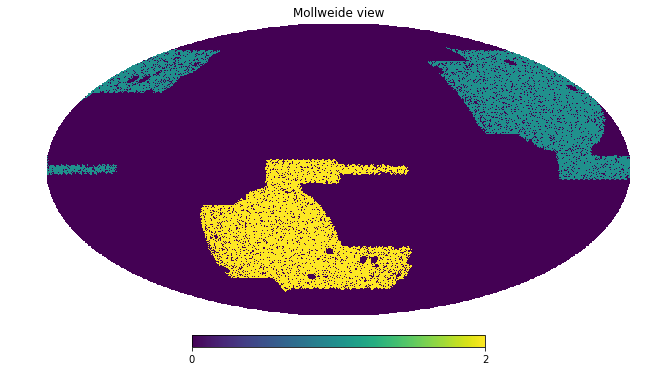

In [10]:
hp.mollview(mask_y3)

In [11]:
theta, phi = hp.pix2ang(8192, np.arange(hp.nside2npix(8192)))
pix = hp.ang2pix(nside, theta, phi)
mask_maps = (mask_y3[pix]==2)

In [12]:
ra = phi/np.pi*180
dec = 90. - theta/np.pi*180

In [13]:
kappa = hp.read_map('/Users/chihwaychang/Work/5x2_related/xcorr/flask/kappa-gamma-f10z1.fits', field=0)


NSIDE = 8192
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [14]:
kappa[~mask_maps] = 0
ra = ra[mask_maps]
dec = dec[mask_maps]

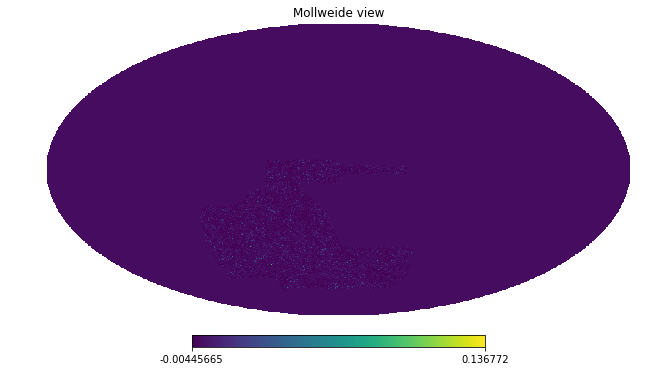

In [15]:
# alm = hp.map2alm(kappa, lmax=8192)
# kappa_4096 = hp.alm2map(alm, nside, lmax=8192)
kappa_4096 = hp.ud_grade(kappa, 4096)
hp.mollview(kappa_4096)

In [16]:
hp.write_map('kappa_flask.fits',kappa_4096)

In [17]:
# JK the kappa map and the lens catalog [maybe can just use the same]
ids = np.arange(len(ra))
np.random.shuffle(ids)
N = 10000
JK, JK_ran = make_jk(ra[ids[:N]], dec[ids[:N]], ra, dec, N=30, dilute_factor=1, rand_out=1, large_mem=True, maxiter=500, tol=1e-05, seed=100)

X (300, 2)  centers (30, 2)  tol=1e-05  maxiter=500
11 iterations  cluster sizes: [ 9 10  6  7  5 14  7 15 11 14  9 14 10  9  6 11  5  3 13  5  8 14 12 16
  3 11 18 12 10 13]
X (10000, 2)  centers (30, 2)  tol=1e-05  maxiter=500
65 iterations  cluster sizes: [240 414 343 309 370 322 272 461 325 345 373 360 291 351 419 365 291 291
 409 309 295 294 307 347 299 315 317 322 334 310]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
[ 7. 18. 23.]
0
[ 7. 18. 23.]
1
[ 0.  7. 18. 23.]
2
[ 0.  7. 18. 23.]
3
[ 0.  7. 18. 23.]
4
[ 0.  7. 18. 23.]
5
[ 0.  7. 18. 23.]
6
[ 0.  7. 18. 23.]
7
[ 0.  7. 18. 23.]
8
[ 0.  7. 18. 23.]
9
[ 0.  7. 18. 23.]
10
[ 0.  5.  7. 18. 23.]
11
[ 0.  5.  7. 18. 23.]
12
[ 0.  1.  5.  7. 18. 23.]
13
[ 0.  1.  5.  7. 18. 23.]
14
[ 0.  1.  5.  7. 18. 23.]
15
[ 0.  1.  5.  7. 11. 18. 23.]
16
[ 0.  1.  5.  7.  9. 11. 18. 23.]
17
[ 0.  1.  5.  7.  9. 11. 18. 23.]
18
[ 0.  1.  5.  7.  9. 11. 18. 23.]
19
[ 0.  1.  5.  7.  9. 11. 18. 23

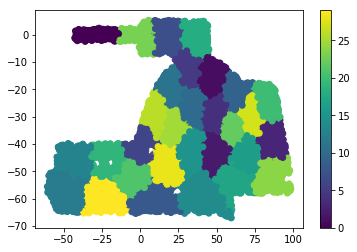

In [18]:
ra_temp = ra[ids[:N]]
ra_temp[ra_temp>180] -= 360
mplot.scatter(ra_temp, dec[ids[:N]], c=JK)
mplot.colorbar()

In [19]:
gamma1 = hp.read_map('/Users/chihwaychang/Work/5x2_related/xcorr/flask/kappa-gamma-f10z1.fits', field=1)
gamma2 = hp.read_map('/Users/chihwaychang/Work/5x2_related/xcorr/flask/kappa-gamma-f10z1.fits', field=2)

NSIDE = 8192
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 8192
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [20]:
gamma1 = gamma1[mask_maps]
gamma2 = gamma2[mask_maps]

In [21]:
# save gamma files
c1 = pf.Column(name='RA', format='E', array=ra)
c2 = pf.Column(name='DEC', format='E', array=dec)
c3 = pf.Column(name='E1', format='E', array=gamma1)
c4 = pf.Column(name='E2', format='E', array=gamma2)
c5 = pf.Column(name='JK', format='K', array=JK_ran)

CC = [c1,c2,c3,c4,c5]
hdu = pf.BinTableHDU.from_columns(CC, nrows=len(ra))
hdu.writeto('gamma_flask.fits', clobber=True)

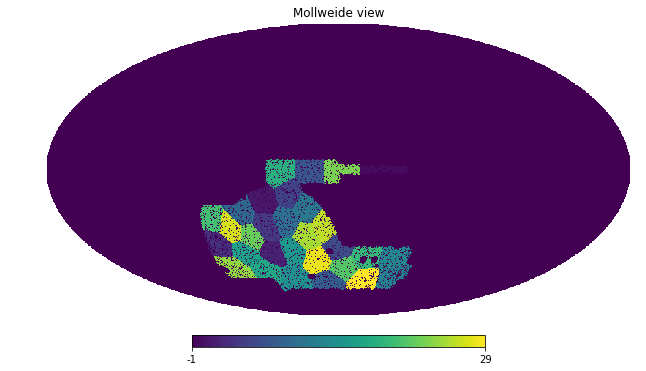

In [22]:
# build the JK mask
mask_y3_jk = np.zeros(hp.nside2npix(nside))-1
pix3 = hp.ang2pix(nside, (90.-dec)*np.pi/180 , ra*np.pi/180)
mask_y3_jk[pix3] = JK_ran
hp.mollview(mask_y3_jk)

In [23]:
hp.write_map('jk_flask.fits',mask_y3_jk, overwrite=True)

In [24]:
# save random files
c1 = pf.Column(name='RA', format='E', array=ra)
c2 = pf.Column(name='DEC', format='E', array=dec)
c3 = pf.Column(name='JK', format='K', array=JK_ran)

CC = [c1,c2,c3]
hdu = pf.BinTableHDU.from_columns(CC, nrows=len(ra))
hdu.writeto('random_flask.fits', clobber=True)

In [25]:
lens = pf.open('/Users/chihwaychang/Work/5x2_related/xcorr/flask/lens-catalog.fits.gz')
lens_bin2 = lens[1].data[lens[1].data['galtype']==2]

In [26]:
ra_bin2 = lens_bin2['ra']
dec_bin2 = lens_bin2['dec']
theta_bin2 = (90.-dec_bin2)*np.pi/180
phi_bin2 = ra_bin2*np.pi/180

jk_bin2 = mask_y3_jk[hp.ang2pix(nside, theta_bin2, phi_bin2)]
select = (jk_bin2!=-1)

In [27]:
# save random files
c1 = pf.Column(name='RA', format='E', array=ra_bin2[select])
c2 = pf.Column(name='DEC', format='E', array=dec_bin2[select])
c3 = pf.Column(name='JK', format='K', array=jk_bin2[select])

CC = [c1,c2,c3]
hdu = pf.BinTableHDU.from_columns(CC, nrows=len(ra_bin2[select]))
hdu.writeto('lens_flask.fits', clobber=True)

In [28]:
print(jk_bin2[select])

[18. 18. 18. ... 14. 14. 14.]
